# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

## Setting up environment:

#### Cleaning up

In [1]:
rm(list = ls())

#### Library Imports

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
#library(plyr)
library(tidyr)
library(RSocrata)
library(ca)
library(forcats)
library(reshape2)
library(lubridate)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Cleaning:

#### Remove Unnecesary Columns and Rename Interesting Columns

In [6]:
code.province.to.province <- function(code) {
    recode(code,
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia")
}

In [7]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           irrigation = ocupaci_n_primera_regad_o, 
           dry = ocupaci_n_primera_secano) %>%
    gather(c(dry, irrigation), 
           key = "crop.technique", value = "area") %>%
    filter(!is.na(area) & area > 0 ) %>%
    mutate(crop = factor(crop),
           crop.group = as.factor(crop.group),
           region = as.factor(region),
           town = as.factor(town),
           province = as.factor(code.province.to.province(code.province))) %>%
    select(-code.province)

In [8]:
crops.woody.use <- crops.woody %>%
    select(a_o, codigo_provincia:municipio,
           superficie_regad_o_en_producci_n,
           superficie_secano_en_producci_n) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           irrigation = superficie_regad_o_en_producci_n, 
           dry = superficie_secano_en_producci_n) %>%
    gather(c(dry, irrigation), 
           key = "crop.technique", value = "area") %>%
    filter(!is.na(area) & area > 0 ) %>%
    mutate(crop = as.factor(crop),
           crop.group = as.factor(crop.group),
           region = as.factor(region),
           town = as.factor(town),
           province = as.factor(code.province.to.province(code.province)),
           year = year(round(as.POSIXct(year), "days")),
           crop.group = recode(crop.group, 
                               "VIÑEDO OCUPACIÓN PRINCIPAL" = "VIÑEDO",
                               "CITRICOS" = "FRUTALES"),
           crop.group = replace(crop.group, crop == "MIMBRERO" | crop == "MORERA Y OTROS", "OTROS CULTIVOS LEÑOSOS"),
           crop.group = replace(crop.group, crop == "OLI ACEITUNA ACEITE" | crop == "OLIVAR ACEIUNA MESA", "OLIVAR")) %>%
    select(-code.province)

In [9]:
crops.woody.use %>%
    select(crop.group) %>%
    pull(crop.group) %>%
    droplevels() %>%
    levels()
# crops.woody.use %>%
#    select(crop.group, crop) %>%
#    filter(crop.group == "VIÑEDO") %>%
#    pull(crop) %>%
#    droplevels() %>%
#    levels()
#
# crops.woody.use %>%
#    select(crop.group, crop) %>%
#    filter(crop.group == "VIÑEDO OCUPACIÓN PRINCIPAL") %>%
#    pull(crop) %>%
#    droplevels() %>%
#    levels()
#
# crops.woody.use %>%
#     select(crop.group, crop) %>%
#     filter(crop.group == "CITRICOS") %>%
#     pull(crop) %>%
#     droplevels() %>%
#     levels()
crops.woody.use %>%
    select(crop.group, crop) %>%
    filter(crop.group == "OLIVAR") %>%
    pull(crop) %>%
    droplevels() %>%
    levels()
crops.woody.use %>%
    select(crop.group, crop) %>%
    filter(crop.group == "OLIVAR Y OTROS C.I.") %>%
    pull(crop) %>%
    droplevels() %>%
    levels()

crops.woody.use %>%
    select(crop.group, crop) %>%
    filter(crop.group == "OTROS CULTIVOS LEÑOSOS") %>%
    pull(crop) %>%
    droplevels() %>%
    levels()

[1] "FRUTALES"               "OLIVAR"                 "OTROS CULTIVOS LEÑOSOS"
[4] "VIÑEDO"                 "VIVEROS"

[1] "OLI ACEITUNA ACEITE" "OLIVAR ACEIUNA MESA"

character(0)

[1] "MIMBRERO"       "MORERA Y OTROS"

In [11]:
crops.use <- rbind(crops.woody.use %>% mutate(crop.type = factor("woody")), 
                   crops.herbaceous.use %>% mutate(crop.type = factor("herbaceous")))

## Data Exploration:

#### View Data Sample

In [12]:
sample_n(crops.use, 10)

year,region,crop,crop.group,town,crop.technique,area,province,crop.type
2016,VITIGUDINO,OLI ACEITUNA ACEITE,OLIVAR,VILLARINO,dry,27,Salamanca,woody
2013,PISUERGA,"Habas, guisantes, altramuces, alhova, algarrobas y otros.",CULTIVOS FORRAJEROS,ITERO DEL CASTILLO,dry,34,Burgos,herbaceous
2011,BENAVENTE Y LOS VALLES,PATATA TARDIA,TUBERCULOS,NAVIANOS DE VALVERDE,irrigation,3,Zamora,herbaceous
2012,AVILA,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,TORRE (LA),irrigation,2,Ávila,herbaceous
2014,PISUERGA,ESPARCETA,CULTIVOS FORRAJEROS,PALACIOS DE RIOPISUERGA,dry,1,Burgos,herbaceous
2012,VITIGUDINO,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,CIPEREZ,dry,98,Salamanca,herbaceous
2016,BIERZO,PATATA TARDIA,TUBERCULOS,CARRACEDELO,irrigation,5,León,herbaceous
2014,AREVALO-MADRIGAL,CEBADA,CEREALES GRANO,VIÑEGRA DE MORAÑA,irrigation,6,Ávila,herbaceous
2016,CENTRO,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,ZARATAN,dry,8,Valladolid,herbaceous
2013,AGUILAR,VEZA,LEGUMINOSAS GRANO,SALINAS DE PISUERGA,dry,3,Palencia,herbaceous


In [13]:
summary(crops.use)

      year                         region            crop       
 Min.   :2010   CAMPOS                : 10689   CEBADA : 19305  
 1st Qu.:2011   CUELLAR               :  9783   TRIGO  : 17031  
 Median :2013   DUERO BAJO            :  8400   GIRASOL: 14123  
 Mean   :2013   CAMPOS-PAN            :  8350   AVENA  : 12975  
 3rd Qu.:2015   AREVALO-MADRIGAL      :  8343   CENTENO: 11301  
 Max.   :2016   BENAVENTE Y LOS VALLES:  8063   ALFALFA: 10584  
                (Other)               :150839   (Other):119148  
                crop.group             town        crop.technique    
 CEREALES GRANO      :73516   TORO       :   499   Length:204467     
 CULTIVOS FORRAJEROS :41015   CUELLAR    :   387   Class :character  
 LEGUMINOSAS GRANO   :29436   VALLADOLID :   366   Mode  :character  
 CULTIV. INDUSTRIALES:25781   TORDESILLAS:   343                     
 HORTALIZAS          :12645   FUENTESAUCO:   328                     
 TUBERCULOS          : 6903   ZAMORA     :   322            

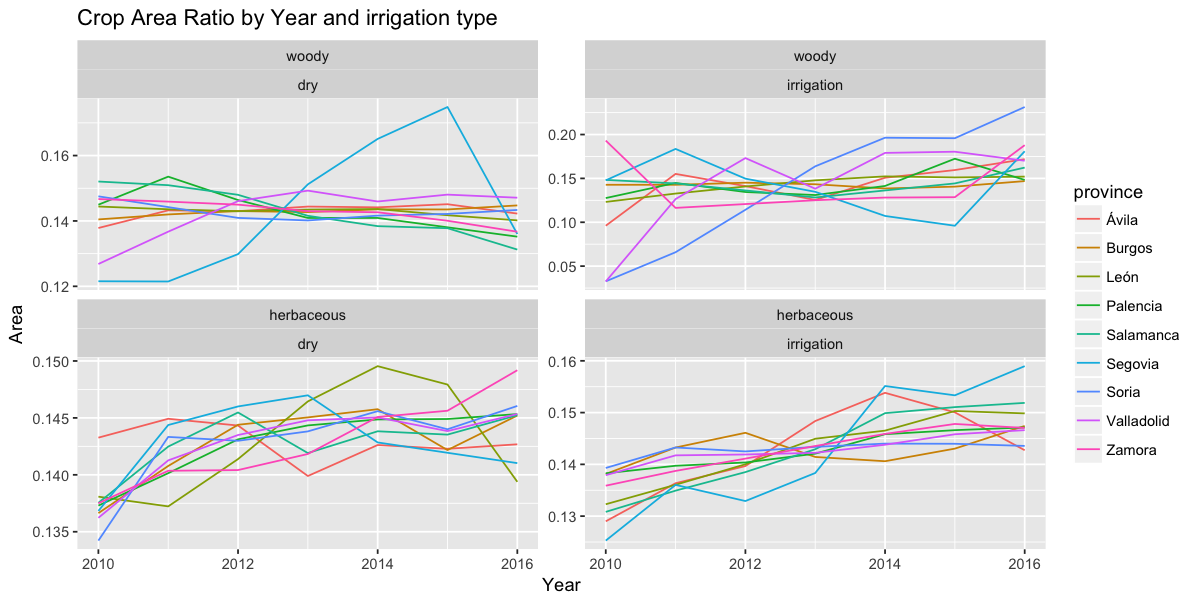

In [14]:
options(repr.plot.width = 10, repr.plot.height = 5)
crops.use %>%
    select(year, area, crop.type, crop.technique, province) %>%
    group_by(year, crop.type, crop.technique, province) %>%
    summarise(area = sum(area)) %>%
    group_by(crop.type, crop.technique, province) %>%
    mutate(area = area / sum(area)) %>%
    ggplot(aes(x=year, y = area, 
               group = province,
               col = province)) +
        labs(title = "Crop Area Ratio by Year and irrigation type", 
             x = "Year", y = "Area") + 
        facet_wrap( ~ crop.type + crop.technique, scales = "free_y") +
        geom_line()

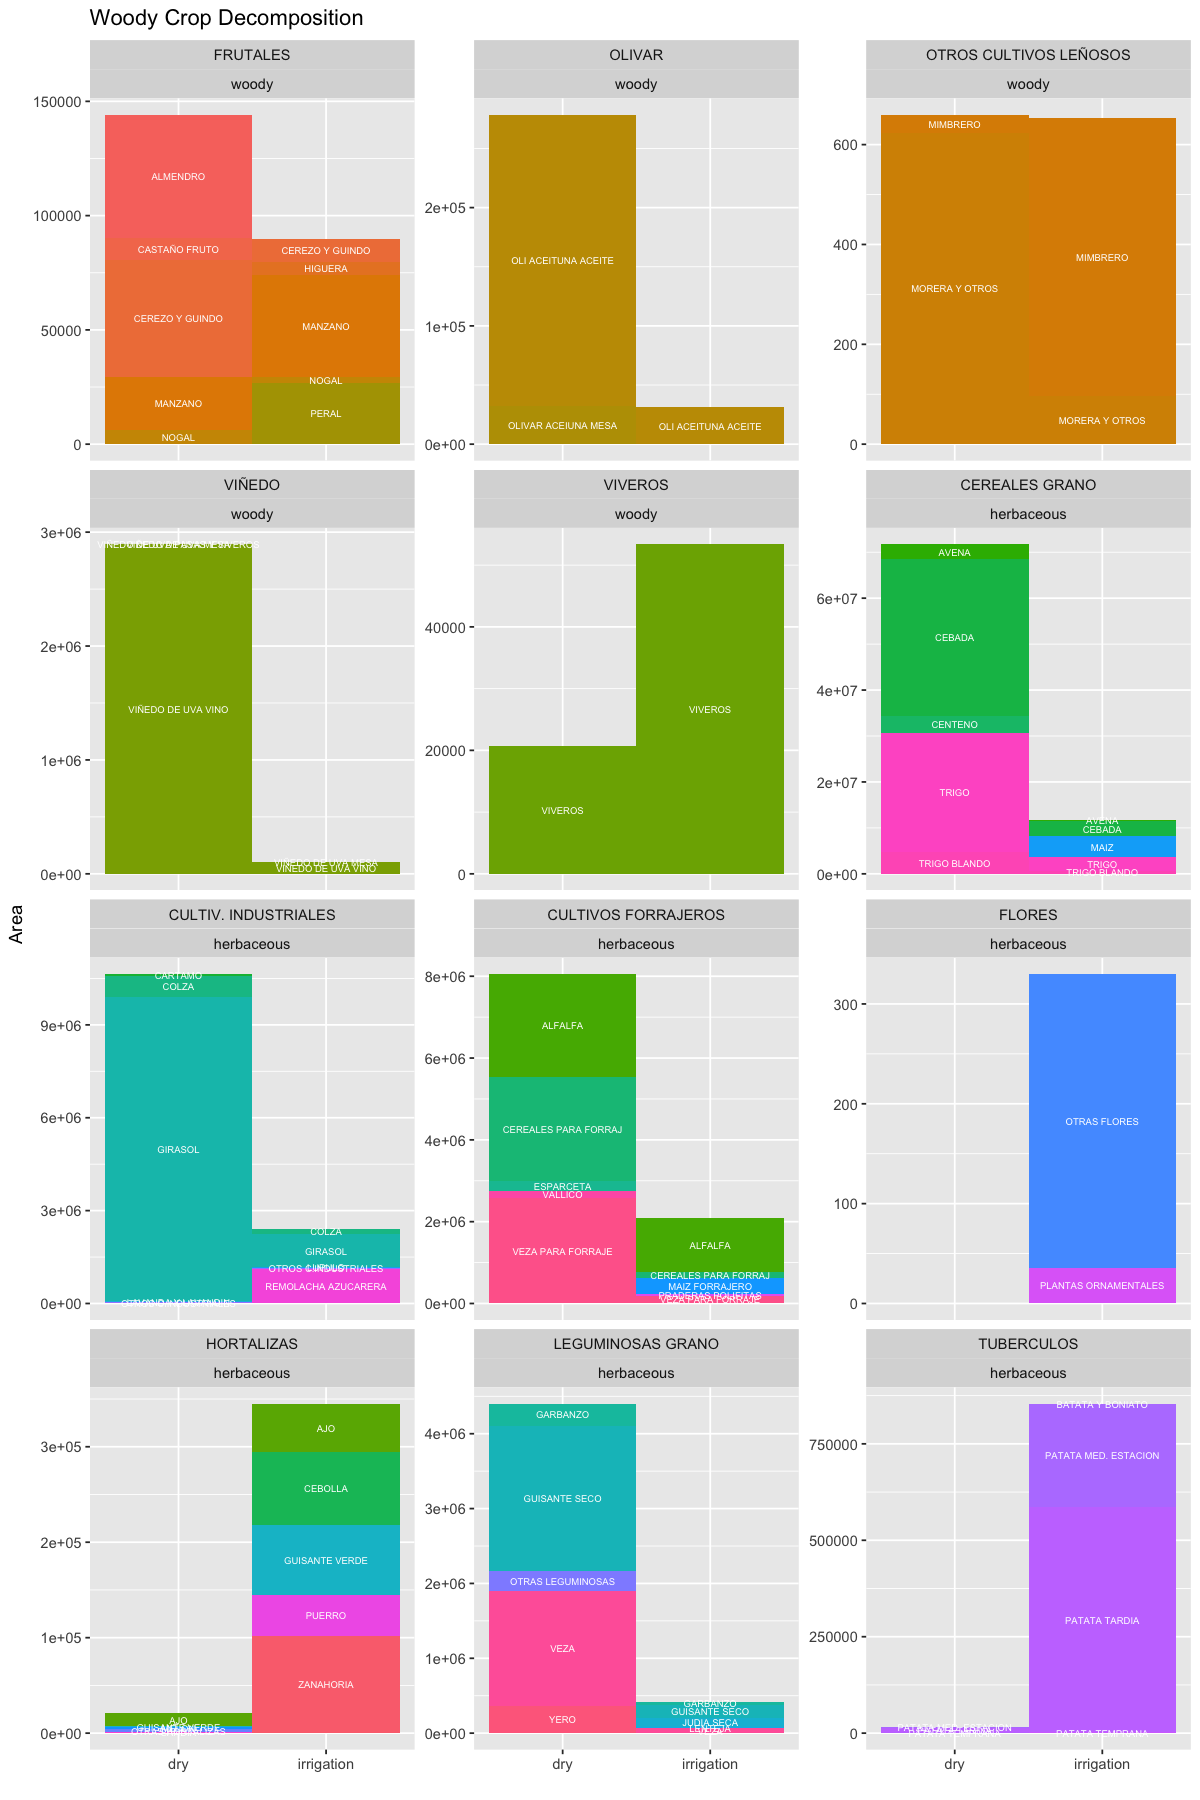

In [15]:
options(repr.plot.width = 10, 
        repr.plot.height = 15)
crops.use %>%
    select(crop, crop.type, crop.group, crop.technique, area, year) %>%
    group_by(crop.group, crop.type, crop.technique, crop) %>%
    summarise(area = sum(area) * (max(crops.use$year) - min(crops.use$year))) %>%
    top_n(5, area) %>%
    ggplot(aes(x = crop.technique, y = area, fill = crop, label = crop )) + 
        geom_bar(width = 1, stat = "identity") +
        theme(legend.position='none') + 
        labs(title = "Woody Crop Decomposition", 
             x = "", y = "Area") + 
        facet_wrap(crop.group ~ crop.type, scales = "free_y", ncol = 3)+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5), 
                  colour = "white") 

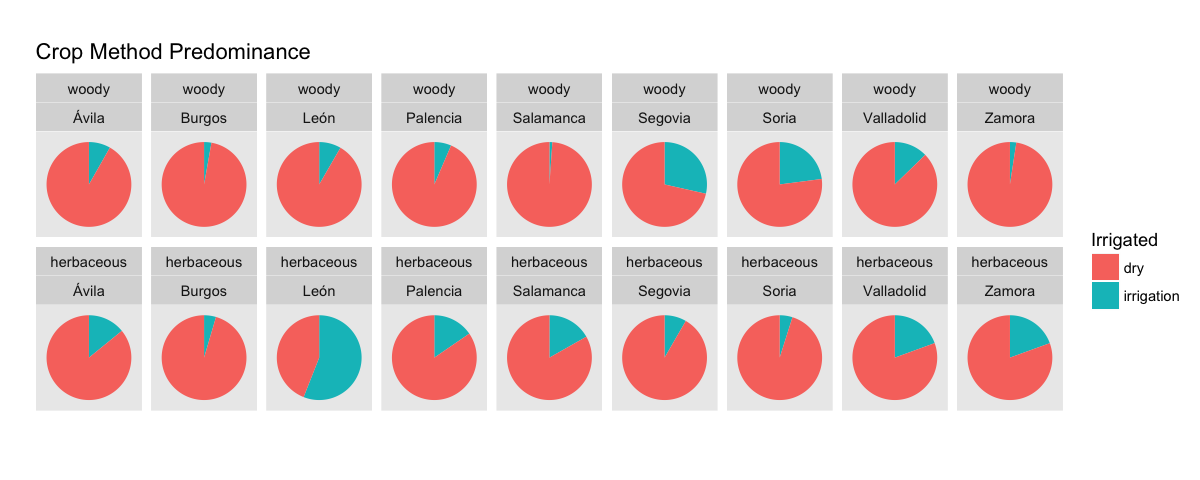

In [16]:
options(repr.plot.width = 10, 
        repr.plot.height = 4)
crops.use %>%
    select(area, crop.type, crop.technique, province) %>%
    group_by(province, crop.type, crop.technique) %>%
    summarise(area = sum(area)) %>%
    group_by(province, crop.type) %>%
    mutate(area = area / sum(area)) %>%
    ggplot(aes(x = "", y = area, fill = crop.technique)) +
        geom_bar(stat = "identity", width = 1) +
        labs(title = "Crop Method Predominance", 
             x = "", y = "", fill = "Irrigated") +
        coord_polar(theta = "y") + 
        facet_wrap(crop.type ~ province, ncol= 9) +
        theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid  = element_blank())
        

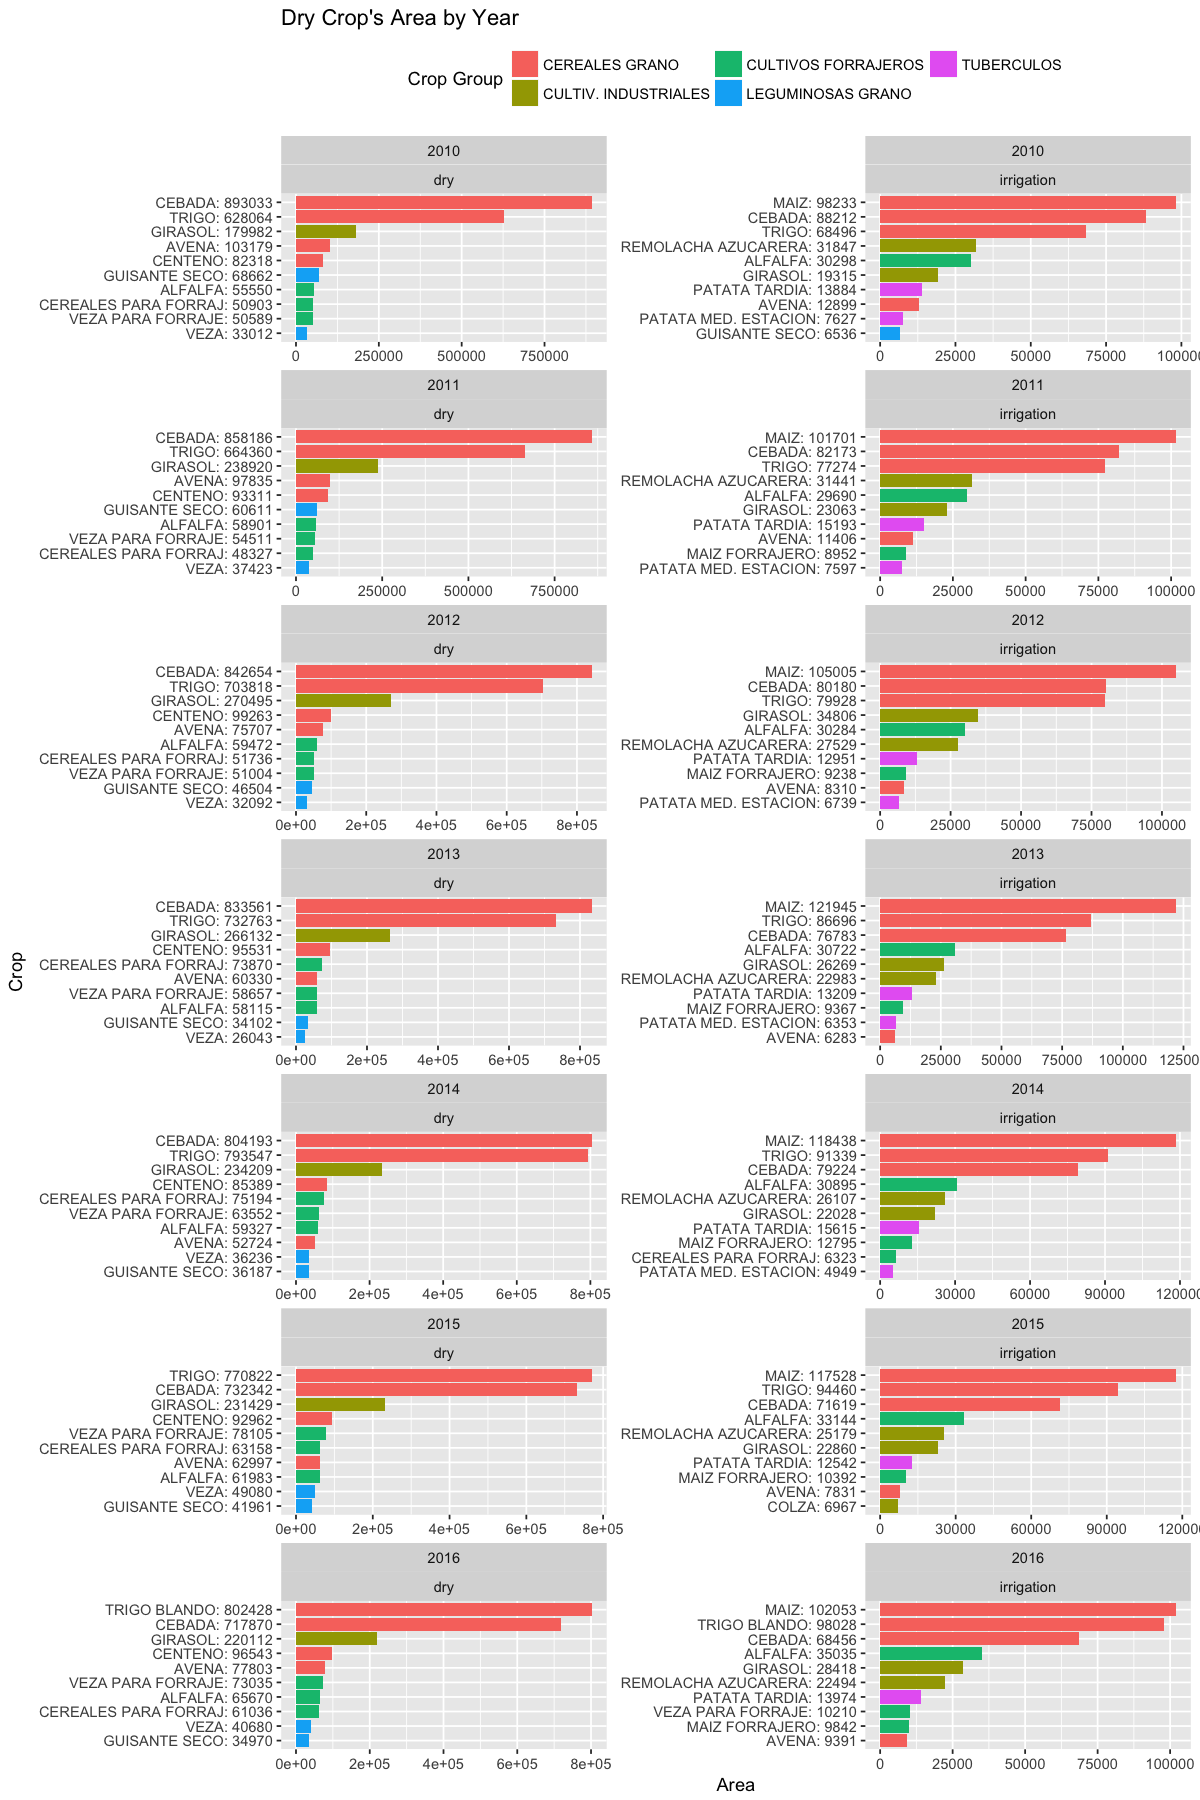

In [17]:
options(repr.plot.width = 10, 
        repr.plot.height = 15)
crops.herbaceous.use %>%
  select(year, crop.technique, crop.group, crop, area) %>%
  group_by(year, crop.technique, crop.group, crop) %>%
  summarise(area = sum(area)) %>%
  group_by(year, crop.technique) %>%
  top_n(10, area) %>%
  arrange(area, .by_group = TRUE) %>%
  mutate(a = row_number()) %>%
  ggplot(aes( fill = crop.group)) + 
    geom_col(aes(x = interaction(crop, area, sep = ": "), y = area)) + 
    theme(legend.position = 'top') +  
    guides(fill = guide_legend(nrow = 2)) +
    labs(title = "Dry Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(year ~ crop.technique, scales = "free", ncol = 2) 

### Correspondence Analysis

In [18]:
crops.woody.use.ca <- crops.woody.use %>%
    select(crop.group, province, area) %>%
    filter(area > 0) %>%
    xtabs(formula = area ~ .,
          drop.unused.levels = TRUE) %>%
    ca()
summary(crops.woody.use.ca)

Warning message in abbreviate(rnames.temp, 4):
“abbreviate used with non-ASCII chars”Warning message in abbreviate(cnames.temp, 4):
“abbreviate used with non-ASCII chars”


Principal inertias (eigenvalues):

 dim    value      %   cum%   scree plot               
 1      0.347638  59.3  59.3  ***************          
 2      0.185947  31.7  91.0  ********                 
 3      0.047908   8.2  99.1  **                       
 4      0.005112   0.9 100.0                           
        -------- -----                                 
 Total: 0.586604 100.0                                 


Rows:
    name   mass  qlt  inr     k=1 cor ctr     k=2 cor ctr  
1 | FRUT |   72  478  128 |  -686 449  97 |   174  29  12 |
2 | OLIV |   85  972  460 | -1750 967 750 |   131   5   8 |
3 | OTRO |    0   95   10 | -1187  87   1 |   344   7   0 |
4 | VIÑE |  823  981   91 |   249 950 147 |    45  31   9 |
5 | VIVE |   20  999  312 |  -314  11   6 | -2980 988 971 |

Columns:
    name   mass  qlt  inr     k=1 cor ctr     k=2 cor ctr  
1 | Ávil |  105  957  222 | -1087 952 357 |   -85   6   4 |
2 | Brgs |  197  990   42 |   333 891  63 |   111  99  13 |
3 | León |  14

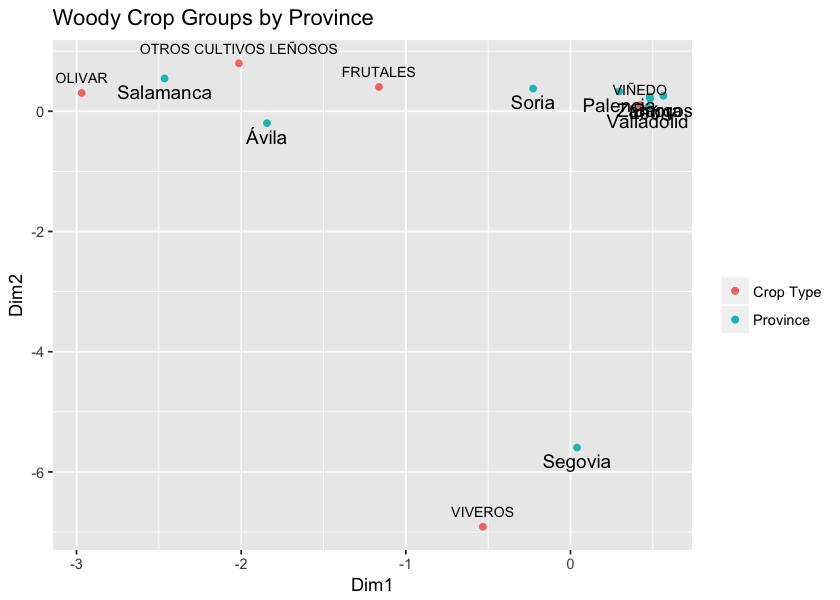

In [19]:
options(repr.plot.width = 7, 
        repr.plot.height = 5)
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Woody Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.woody.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.woody.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.woody.use.ca$rowcoord),
              label=rownames(crops.woody.use.ca$rowcoord), 
              hjust=0.5, vjust=-1, size = 3) +
    geom_text(data = as.data.frame(crops.woody.use.ca$colcoord),
              label=rownames(crops.woody.use.ca$colcoord), 
              hjust=0.5, vjust=1.5, size = 4)


In [20]:
crops.herbaceous.use.ca <- crops.herbaceous.use %>%
    select(crop.group, province, area) %>%
    filter(area > 0) %>%
    xtabs(formula = area ~ .,
          drop.unused.levels = TRUE) %>%
    ca()
summary(crops.herbaceous.use.ca)

Warning message in abbreviate(cnames.temp, 4):
“abbreviate used with non-ASCII chars”


Principal inertias (eigenvalues):

 dim    value      %   cum%   scree plot               
 1      0.040207  66.8  66.8  *****************        
 2      0.010250  17.0  83.8  ****                     
 3      0.005735   9.5  93.4  **                       
 4      0.002417   4.0  97.4  *                        
 5      0.001570   2.6 100.0  *                        
 6      8e-06000   0.0 100.0                           
        -------- -----                                 
 Total: 0.060187 100.0                                 


Rows:
       name   mass  qlt  inr    k=1 cor ctr    k=2 cor ctr  
1 |    CERE |  736  947   59 |  -53 586  52 |   42 361 125 |
2 | CULTIVI |  114  690   89 | -160 543  73 |  -83 148  77 |
3 | CULTIVO |   92  997  576 |  615 997 860 |   -1   0   0 |
4 |    FLOR |    0   27    0 | -113   3   0 |  306  24   0 |
5 |    HORT |    5  426   92 | -290  76  10 | -623 350 189 |
6 |    LEGU |   46  809  122 |   31   6   1 | -359 803 576 |
7 |    TUBE |    8  138  

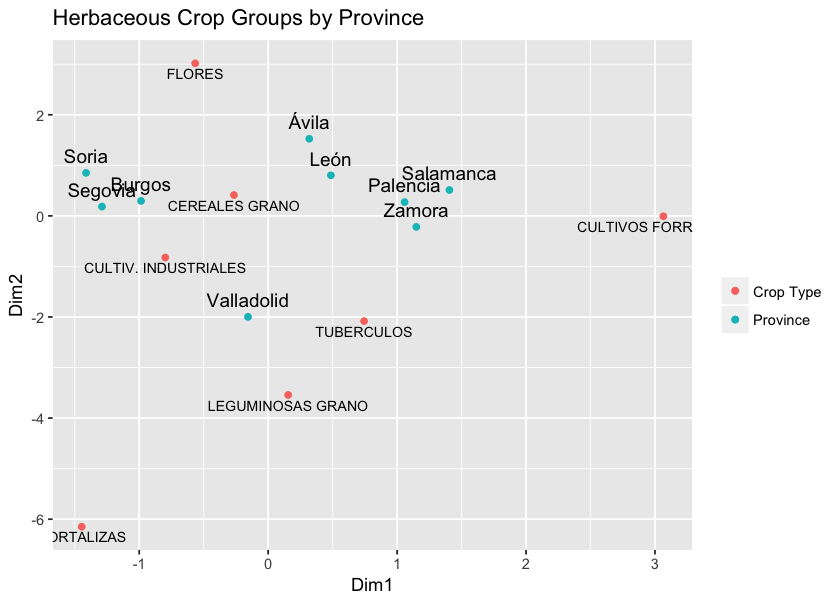

In [21]:
options(repr.plot.width = 7, 
        repr.plot.height = 5)
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Herbaceous Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$rowcoord),
              label=rownames(crops.herbaceous.use.ca$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$colcoord),
              label=rownames(crops.herbaceous.use.ca$colcoord), 
              hjust=0.5, vjust=-0.75, size = 4)